# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle
from skimage import exposure,color

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'datasets/traffic-signs-data/train.p'
testing_file = 'datasets/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)


    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [5]:
# COnvert to Grayscale
X_train= color.rgb2gray(X_train)
X_test = color.rgb2gray(X_test)

In [10]:
for i in range(len(X_test)):
    X_test[i] = exposure.equalize_adapthist(X_test[i])

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [24]:
# CLAHE
for i in range(len(X_train)):
    X_train[i] = exposure.equalize_adapthist(X_train[i])

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [31]:
### Replace each question mark with the appropriate value.
import numpy as np

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [32]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

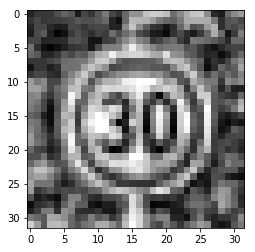

In [30]:
plt.imshow(X_train[554,:,:],cmap='gray')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [42]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

In [33]:
import pandas as pd

from sklearn import preprocessing,metrics
from scipy import ndimage,misc
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 
import skimage
import cv2
import math
import random

In [34]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def normalize_greyscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 1
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )

In [31]:
#Convert to grayscale
#X_train = rgb2gray(X_train) 
#X_test =rgb2gray(X_test)

In [37]:
X_train.min()

0.0

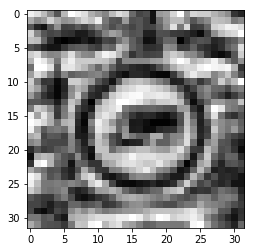

In [38]:
plt.imshow(X_test[112,:,:],cmap='gray')

In [39]:
# Helper functions
def flatten_data(X):
    "X is 3D in shape"
    X_flat=[]
    for i in range(len(X)):
        X_flat.append(X[i,:,:].flatten())
    return np.array(X_flat)

def load2d(X):
    X =X.reshape(-1, 32, 32,1)
    return X

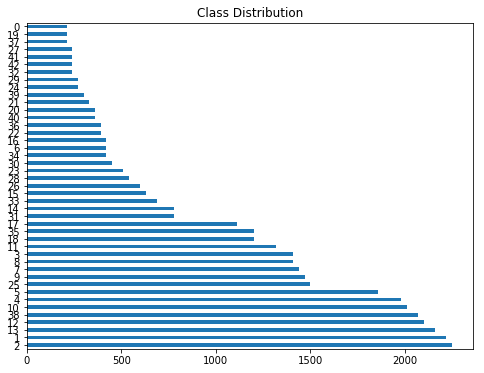

In [40]:
class_count = pd.DataFrame(y_train)
class_count.columns = ['class']
class_freq =pd.value_counts(class_count['class'].values, sort=True)
class_freq.plot.barh(figsize=(8,6))
plt.title("Class Distribution")
plt.show()

In [41]:
class_freq.mean()

911.83720930232562

In [42]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

In [43]:
# PARAMETERS
augment_data = True

In [44]:
class_dict = class_freq.to_dict()

In [45]:
# Data Generation
im_x=32;im_y=32

def crop_around_center(image, width, height):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point
    """

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))
    
    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]

def aug_rotate(im,rot_val):
        image_rotated = skimage.transform.rotate(im,rot_val,resize=True)
        image_rotated_cropped = crop_around_center(image_rotated,im_x,im_y)
        return image_rotated_cropped
def aug_scale(im,scale_val):
        #scale and resize
        im_zoom= resize(skimage.transform.rescale(im,scale_val),(im_x,im_y))
        return im_zoom

if augment_data:
    from joblib import Parallel, delayed
    import multiprocessing

    # what are your inputs, and what operation do you want to 
    # perform on each input. For example...
    inputs = range(X_train.shape[0]) 

    def processInput(i):
        data_aug=[]
        label_aug=[]
        im=X_train[i,:,:]
        if class_dict[y_train[i]] < class_freq.mean():
            limit=6
        else:
            limit=2
        
        scale = [round(random.uniform(0.5,5),2) for i in range(limit)]
        for scale_val in scale:
            data_aug.append(aug_scale(im,scale_val))
            label_aug.append(y_train[i])
        angles= [random.randint(-90,90) for i in range(limit)]    
        for rot_val in angles:
            data_aug.append(aug_rotate(im,scale_val))
            label_aug.append(y_train[i])
        return [data_aug,y_train[i]]

    num_cores = multiprocessing.cpu_count()
    results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)

In [46]:
data_aug=[]
label_aug=[]
for item in results:
    for data in item[0]:
        data_aug.append(data)
        label_aug.append(item[1])
del results # cleanup

# Add additional data to training set
X_train = np.concatenate((X_train,np.array(data_aug)))
y_train = np.concatenate((y_train,np.array(label_aug)))

#del data_aug,label_aug

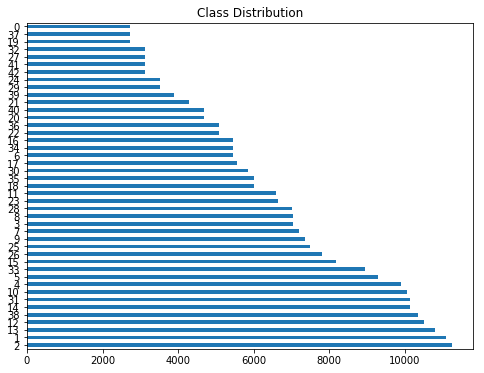

In [51]:
class_count = pd.DataFrame(y_train)
class_count.columns = ['class']
class_freq =pd.value_counts(class_count['class'].values, sort=True)
class_freq.plot.barh(figsize=(8,6))
plt.title("Class Distribution")
plt.show()

**Answer:**

In [52]:
# SHUFFLE Data
X_train, y_train = shuffle(X_train,  y_train, random_state=0)

In [54]:
# SCale Data between 0 and 1
X_train_flat = flatten_data(X_train)
X_test_flat = flatten_data(X_test)

#min_max_scaler = preprocessing.MinMaxScaler()
#X_tr = load2d(min_max_scaler.fit_transform(X_train_flat))
#X_ts = load2d(min_max_scaler.transform(X_test_flat))

In [55]:
X_tr = load2d(X_train_flat)
X_ts = load2d(X_test_flat)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [56]:
X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_train, test_size=0.40, random_state=42)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [57]:
import tensorflow as tf

In [58]:
# Parameters
EPOCHS = 12
BATCH_SIZE = 64
#n_input = 1024  # MNIST data input (img shape: 28*28)
n_classes = 43  # MNIST total classes (0-9 digits)

In [59]:
n_hidden_layer = 256 # layer number of features

In [60]:
from math import ceil
in_height=32
in_width =32
filter_height =2; filter_width=2;strides = [1,1,1,1]

In [61]:
out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
out_width  = ceil(float(in_width - filter_width + 1) / float(strides[2]))
print(out_height)
print(out_width)

31
31


In [62]:
3*3*64

576

In [63]:
from tensorflow.contrib.layers import flatten


def my_Net(x):
    mu = 0
    sigma = 0.1
    
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 30x30x16.
    # -------------------------------
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 30x30x16. Output = 15x15x16.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #Lrn
    #conv1 = tf.nn.lrn(conv1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    
    # Dropput Layer
    #conv1 = tf.nn.dropout(conv1,keep_prob)
    # ---------------------------------

    # SOLUTION: Layer 2: Convolutional. Input = 15x15x16. Output = 14x14x32.
    # ---------------------------------
    conv2_W = tf.Variable(tf.truncated_normal(shape=(2, 2, 16, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 14x14x16. Output = 7x7x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #Lrn
    #conv1 = tf.nn.lrn(conv1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    
    # Dropput Layer
    conv2 = tf.nn.dropout(conv2,keep_prob)
    # ---------------------------------

    # SOLUTION: Layer 3: Convolutional. Input = 7x7x16. Output = 6x6x32.
    # ---------------------------------
    conv3_W = tf.Variable(tf.truncated_normal(shape=(2, 2, 32, 64), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
     # SOLUTION: Activation.
    conv3 = tf.nn.relu(conv3)

    # SOLUTION: Pooling. Input = 6x6x32. Output = 3x3x32.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #Lrn
    #conv1 = tf.nn.lrn(conv1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    
    # Dropput Layer
    conv3 = tf.nn.dropout(conv3,keep_prob)
    # ---------------------------------
    
    # SOLUTION: Flatten. Input = 3x3x64. Output = 288. 
    fc0   = flatten(conv3)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 288. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(576, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


def LeNet_mod(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #Lrn
    #conv1 = tf.nn.lrn(conv1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    
    # Dropput Layer
    conv1 = tf.nn.dropout(conv1,keep_prob)

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    #Lrn
    #conv1 = tf.nn.lrn(conv1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    
    # Dropput Layer
    conv2 = tf.nn.dropout(conv2,keep_prob)

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [64]:
x = tf.placeholder(tf.float32, (None, 32, 32,1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

In [65]:
rate = 0.001

#logits = LeNet_mod(x)
logits = my_Net(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [66]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
prediction=tf.argmax(logits,1)
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data,prob):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:prob})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [67]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_tr)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_tr, y_tr = shuffle(X_tr, y_tr)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_tr[offset:end], y_tr[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
            
        validation_accuracy = evaluate(X_val, y_val,1)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.892

EPOCH 2 ...
Validation Accuracy = 0.948

EPOCH 3 ...
Validation Accuracy = 0.964

EPOCH 4 ...
Validation Accuracy = 0.968

EPOCH 5 ...
Validation Accuracy = 0.973

EPOCH 6 ...
Validation Accuracy = 0.975

EPOCH 7 ...
Validation Accuracy = 0.977

EPOCH 8 ...
Validation Accuracy = 0.982

EPOCH 9 ...
Validation Accuracy = 0.979

EPOCH 10 ...
Validation Accuracy = 0.983

EPOCH 11 ...
Validation Accuracy = 0.986

EPOCH 12 ...
Validation Accuracy = 0.987

Model saved


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**   

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### Performance on Held out Test Data

In [68]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [69]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred=sess.run(prediction, feed_dict={x: X_ts, y: y_test, keep_prob:1})
    pred_acc= evaluate(X_ts,y_test,1)

In [70]:
classes = pd.read_csv('signnames.csv')
class_names =classes.SignName

Confusion matrix, without normalization
[[ 59   0   0 ...,   0   0   0]
 [  1 678  13 ...,   0   0   0]
 [  0   4 727 ...,   0   0   0]
 ..., 
 [  0   0   0 ...,  85   0   0]
 [  0   0   0 ...,   0  56   1]
 [  0   0   0 ...,   0   3  77]]


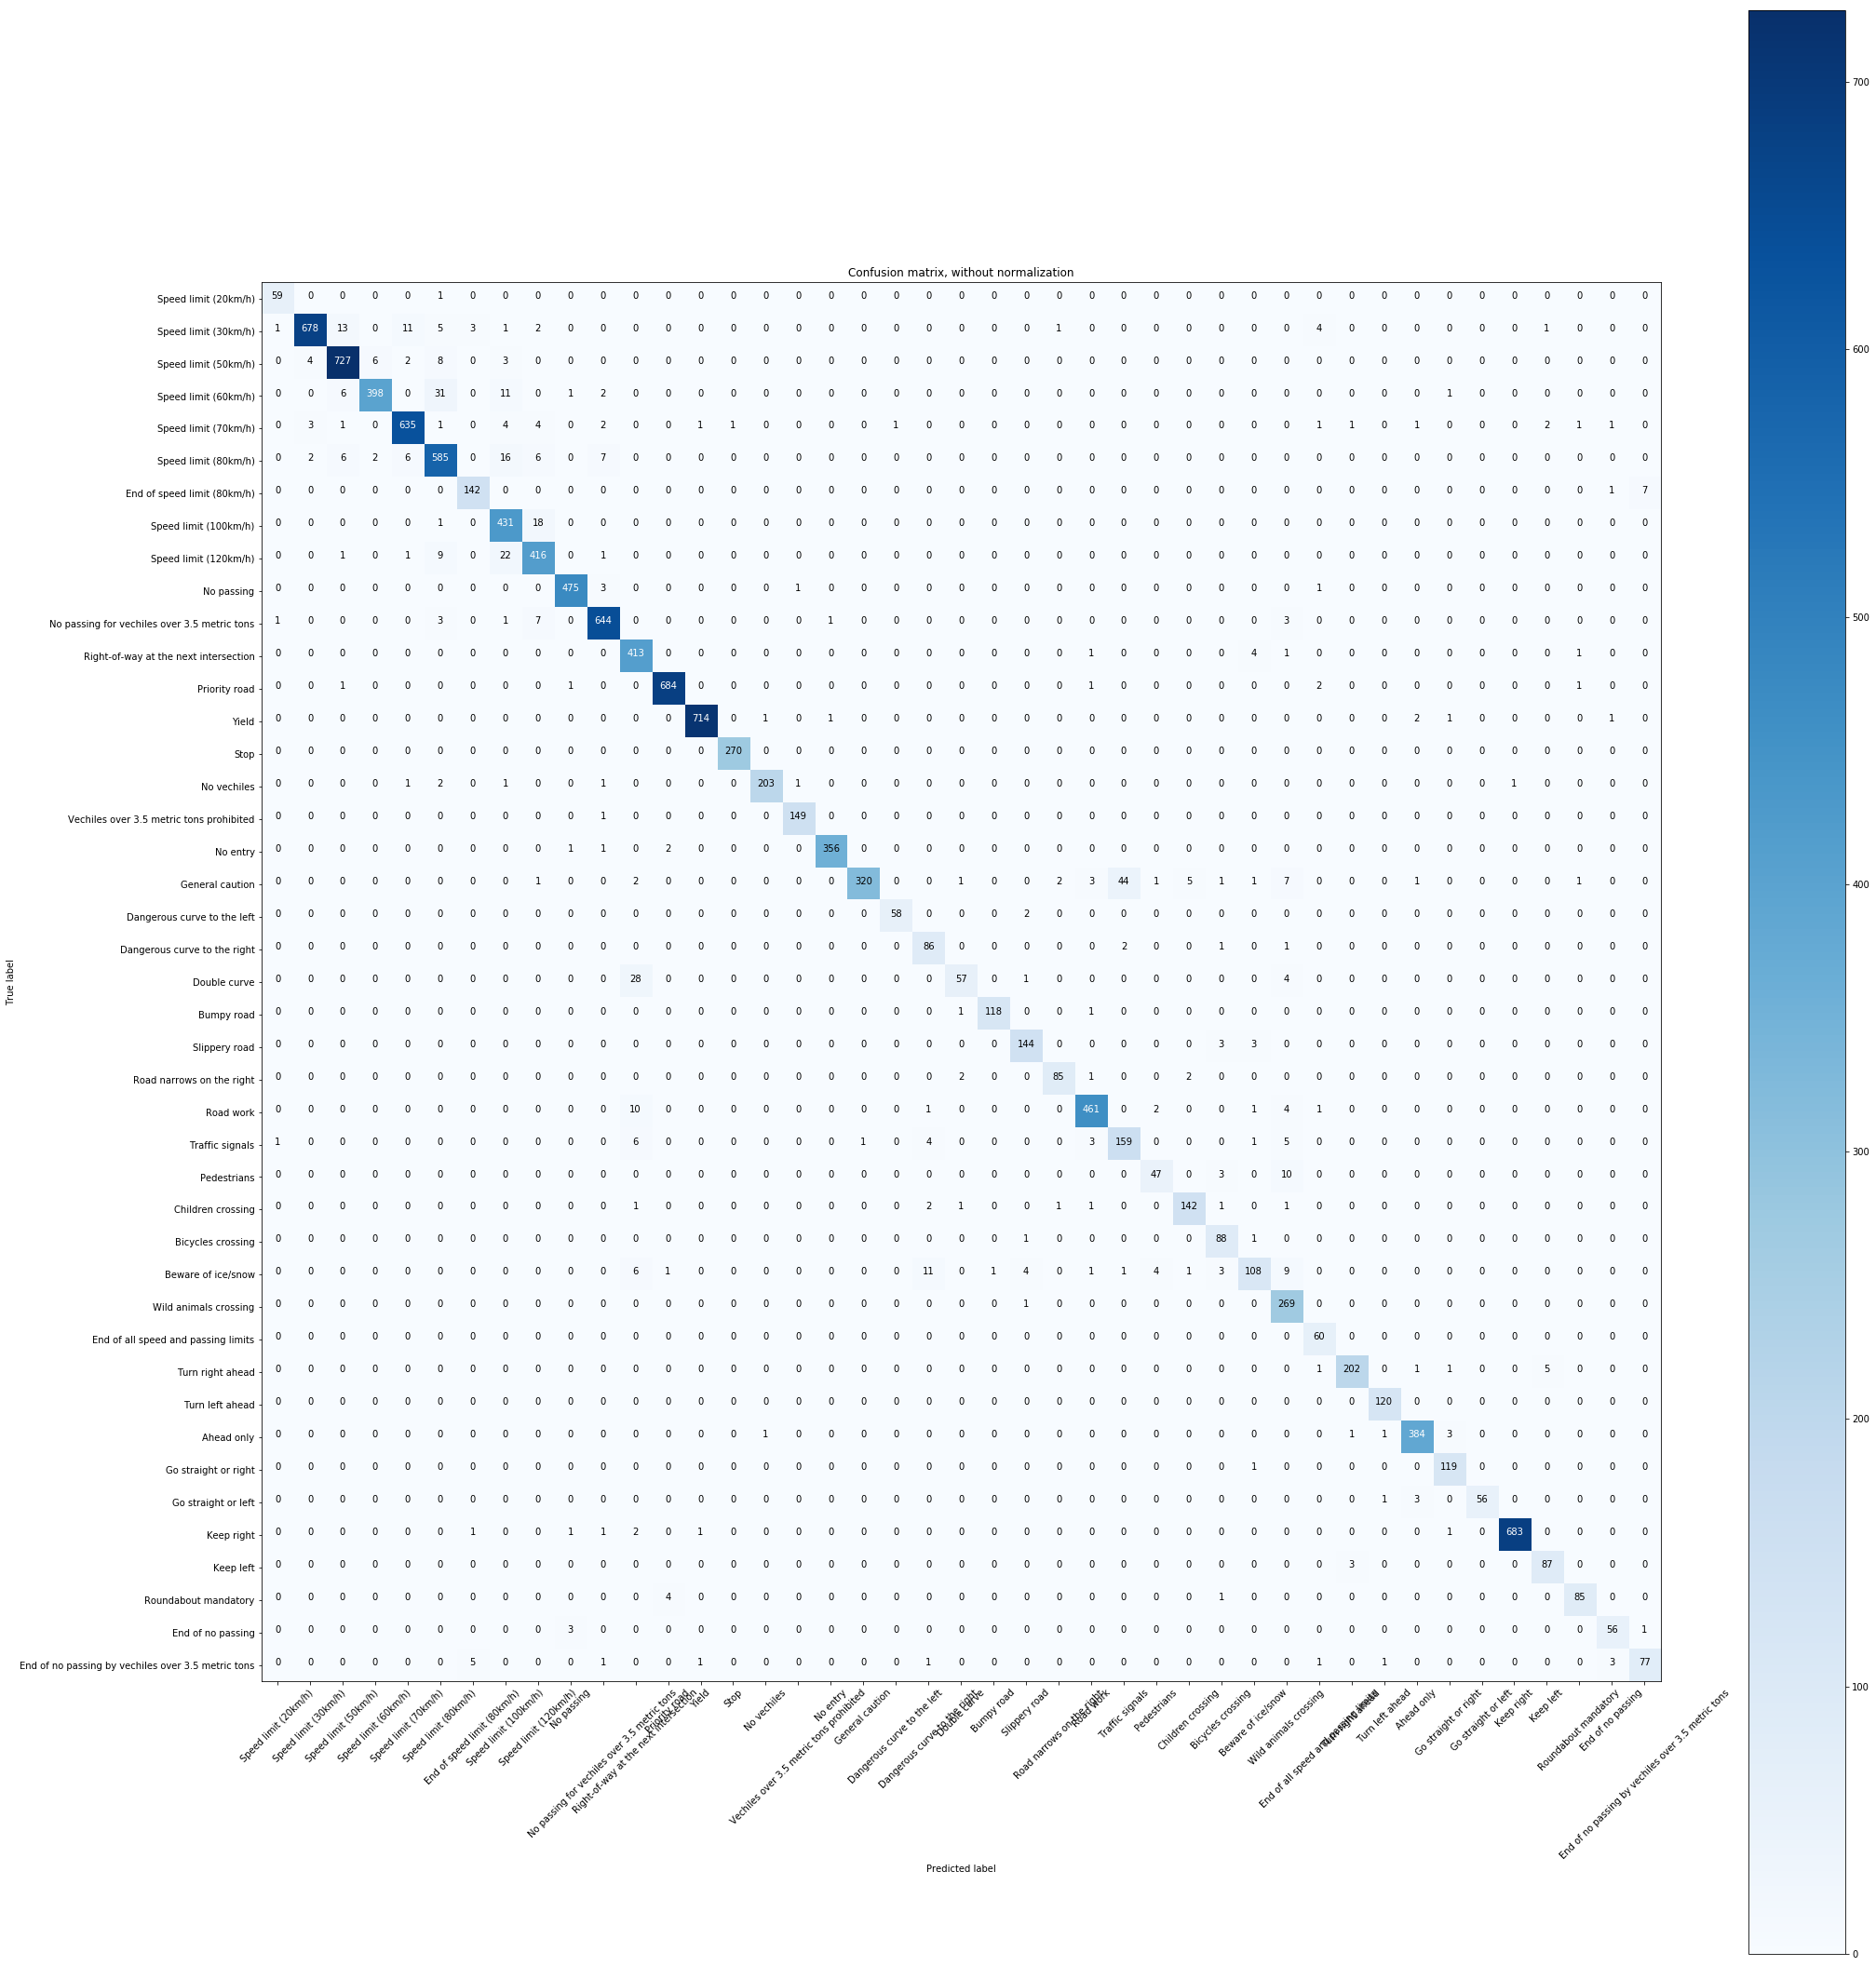

In [71]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(30,30))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.savefig("fig1.png")

# Plot normalized confusion matrix
#plt.figure(figsize=(30,30))
#plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

#plt.savefig("fig2.png")

In [72]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_ts, y_test,1)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.954


In [ ]:
87.3 2 without augmentation 10 epochs
88.6 with augmentation 10 epochs
92.4 with augmentation and droput 20 epochs
93.7 20 Epochs Using myNet inspired from VGG
93.3 12 Epochs Using myNet inspired from VGG

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [160]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
from skimage.data import imread

In [161]:
import glob
ts_imgs=[]
for name in glob.glob('*.jp*'):
    print(name)
    ts_imgs.append(resize(imread(name),(im_x,im_y)))
ts_imgs= np.array(ts_imgs)

uiig-fig8-3.jpg
VegetationGuide_img_6.jpg
sign2.jpg
70.jpeg
sign5.jpg
sign1.jpeg


In [162]:
y_test_ = np.ones(len(ts_imgs))

In [163]:
X_test_ = color.rgb2gray(ts_imgs)
for i in range(len(X_test_)):
    X_test_[i]=exposure.equalize_adapthist(X_test_[i])

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [164]:
X_test_ = load2d(flatten_data(X_test_))

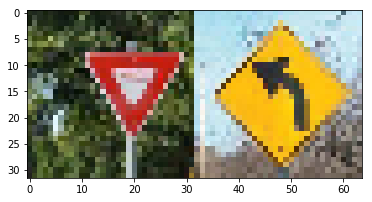

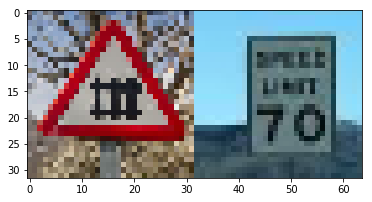

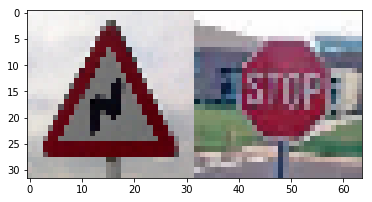

In [166]:
img_A= ts_imgs[0]
for i in range(1,len(ts_imgs),2):
    plot_image = np.concatenate((ts_imgs[i-1], ts_imgs[i]), axis=1)
    plt.figure()
    plt.imshow(plot_image,cmap='gray')
plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


In [168]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred=sess.run(prediction, feed_dict={x: X_test_, y: y_test_, keep_prob:1})
    tmp=sess.run(logits,feed_dict={x: X_test_, y: y_test_, keep_prob:1})

In [169]:
with tf.Session() as sess:
    prob= sess.run(tf.nn.top_k(tmp,k=3))

In [215]:
classes

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [217]:
# Predicted Labels
print("Predicted_labels")
pred

Predicted_labels


array([13, 34, 23, 13, 20, 13])

In [218]:
print("True Labels, -1 is used for not in dataset")
print([13,34,21,-1,4,14])

True Labels, -1 is used for not in dataset
[13, 34, 21, -1, 4, 14]


#### Answer

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [135]:
# softmax probabilities
prob

TopKV2(values=array([[ 1.62,  1.33, -0.47],
       [ 0.26,  0.03, -0.07],
       [ 5.78,  4.06,  1.19],
       [ 3.51,  1.53,  0.26],
       [ 3.81,  2.12,  0.9 ],
       [ 3.52,  2.7 ,  2.37],
       [ 0.88,  0.36, -0.2 ]], dtype=float32), indices=array([[13, 12, 28],
       [34,  1, 35],
       [23, 11, 29],
       [13,  1,  4],
       [ 7,  5,  8],
       [20, 28, 30],
       [13, 14, 15]], dtype=int32))

In [198]:
def plot_closest(indx):
    print("Class indices of predictions")
    print(prob.indices[indx])
    plt.imshow(ts_imgs[indx],cmap='gray')
    plt.show()
    plt.imshow(X_test_[indx,:,:,0],cmap='gray')
    arr= [ random.choice(np.where(y_tr==i)[0]) for i in prob.indices[indx]]
    plot_image = np.concatenate((X_tr[arr[0],:,:,0], X_tr[arr[1],:,:,0]), axis=1)
    plot_image = np.concatenate((plot_image, X_tr[arr[2],:,:,0]),axis=1)
    plt.figure(figsize=(10,8))
    plt.title("Random samples from training data in order of closest predictions")
    plt.imshow(plot_image,cmap='gray')

#### Image 1 : yield sign

Class indices of predictions
[13 12 28]


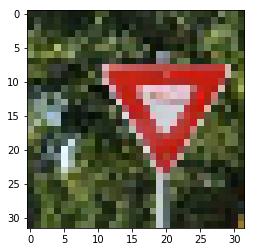

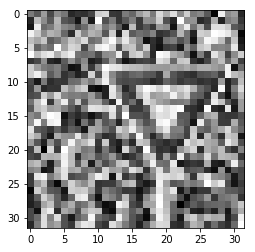

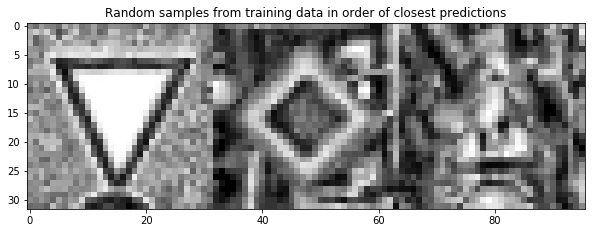

In [200]:
plot_closest(0)

#### Image 2: Turn Left Ahead

Class indices of predictions
[34  1 35]


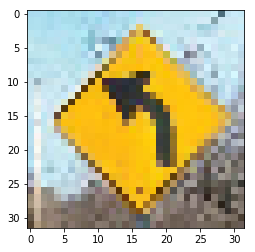

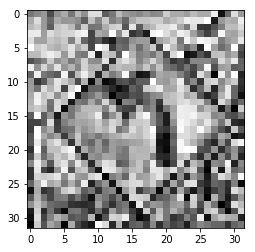

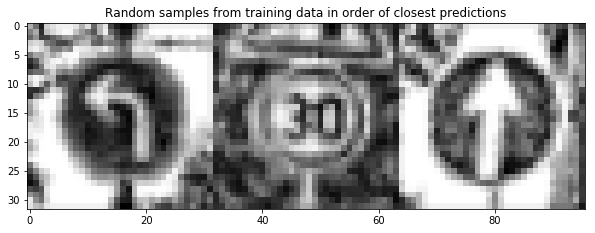

In [201]:
plot_closest(1)

#### Image 3: 

Class indices of predictions
[23 11 29]


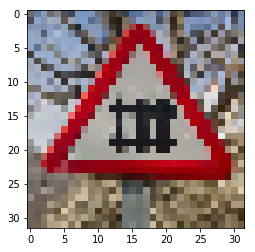

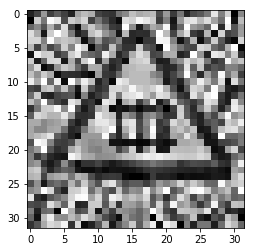

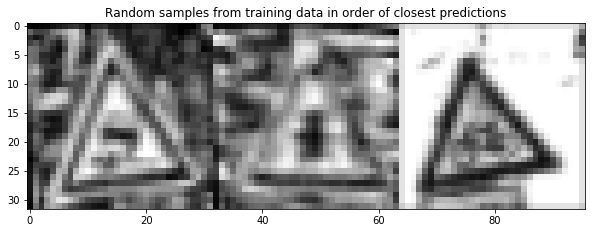

In [203]:
plot_closest(2)

#### Image 4: 

Class indices of predictions
[13  1  4]


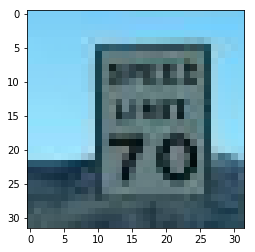

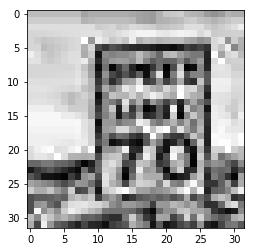

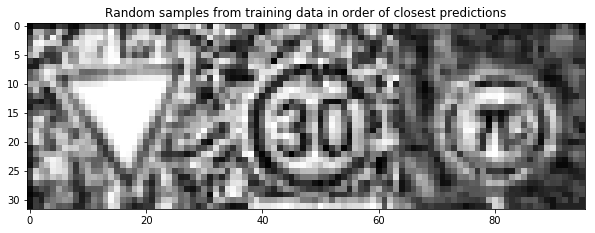

In [202]:
plot_closest(3)

#### Image 5: Double Curve

Class indices of predictions
[20 28 30]


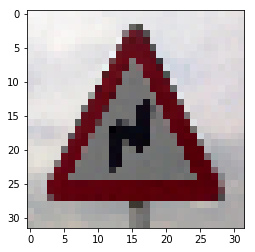

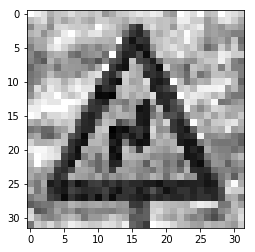

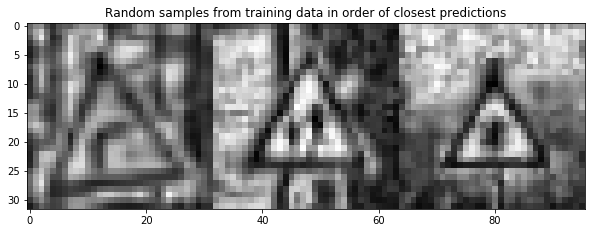

In [208]:
plot_closest(4)

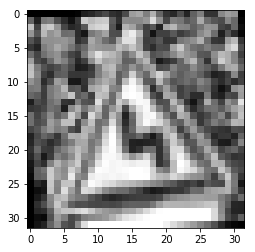

In [210]:
# True label
arr= np.where(y_tr==21)
plt.imshow(X_tr[arr[0][0],:,:,0],cmap='gray')

#### Image 6: Stop Sign

Class indices of predictions
[13 14 15]


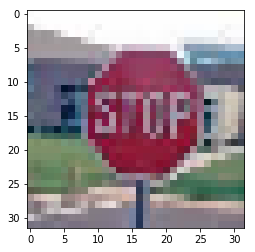

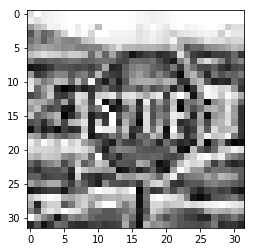

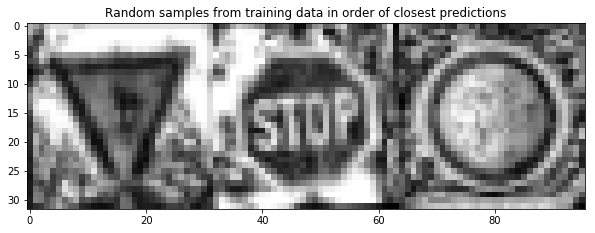

In [213]:
plot_closest(5)

## Conclusion